In [5]:
from __future__ import unicode_literals,print_function,division
from io import open 
import glob 
import os 

In [6]:
def findFiles(path):return glob.glob(path)

In [8]:
print(findFiles('names/*.txt'))

['names\\Arabic.txt', 'names\\Chinese.txt', 'names\\Czech.txt', 'names\\Dutch.txt', 'names\\English.txt', 'names\\French.txt', 'names\\German.txt', 'names\\Greek.txt', 'names\\Irish.txt', 'names\\Italian.txt', 'names\\Japanese.txt', 'names\\Korean.txt', 'names\\Polish.txt', 'names\\Portuguese.txt', 'names\\Russian.txt', 'names\\Scottish.txt', 'names\\Spanish.txt', 'names\\Vietnamese.txt']


In [9]:
import unicodedata
import string

In [12]:
all_letters = string.ascii_letters+" .,;'"
n_letters = len(all_letters)

In [14]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [37]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [16]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [38]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename,encoding = 'utf-8').read().strip().split('\n')
    return lines

In [39]:
for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [40]:
n_categories

18

In [42]:
print(all_categories)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [48]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

In [49]:
letterToIndex('s')

18

In [218]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# print(letterToTensor('J'))

print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


In [87]:
tensor = torch.zeros(1,10)
tensor[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

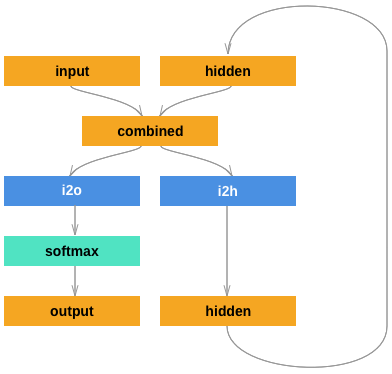

In [161]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden 
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [164]:
nn.Linear(23+12,12)

Linear(in_features=35, out_features=12, bias=True)

In [175]:
m = nn.Linear(185,128) # linear layer 
input_ = torch.randn(1,185)
output = m(input_)
print(output.size())

torch.Size([1, 128])


In [177]:
weight = torch.FloatTensor(185, 128).uniform_(-np.sqrt(185),np.sqrt(185))

In [178]:
weight.shape

torch.Size([185, 128])

In [179]:
input_.shape

torch.Size([1, 185])

In [182]:
torch.matmul(input_,weight).shape

torch.Size([1, 128])

In [185]:
input_ = lineToTensor('Albert')
hidden = torch.zeros(1,n_hidden)
output,next_hidden = rnn(input_[0],hidden)
print(output.shape)
print(output)

torch.Size([1, 18])
tensor([[-2.9906, -2.8062, -2.9136, -2.9396, -2.8104, -2.8962, -3.0116, -2.9553,
         -2.8696, -2.9525, -2.9251, -2.8584, -2.8198, -2.8467, -2.8196, -2.9456,
         -2.9242, -2.7816]], grad_fn=<LogSoftmaxBackward0>)


output is in the shape (1,no_categories) Tensor, where every item is the likelihood of that category. 

Tensor.topk function can be used to get the index of the greatest value. 

In [226]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [202]:
import random 
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

In [207]:
randomChoice(all_categories)

'Russian'

In [209]:
all_categories.index('Russian')

14

In [212]:
def randomTrainingExample():
    category  = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor

In [215]:
for i in range(10):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    print('category = ',category, '/line = ', line )

category =  Vietnamese /line =  Chung
category =  Vietnamese /line =  Trinh
category =  French /line =  Rose
category =  Polish /line =  Jaskulski
category =  Chinese /line =  Moy
category =  Chinese /line =  Chen
category =  Japanese /line =  Jo
category =  Korean /line =  Ryom
category =  Arabic /line =  Asghar
category =  Russian /line =  Jukhno


In [217]:
criterion = nn.NLLLoss()

Each loop of training will: 

    * create input and target tensors 
    * create a zeroed initial hidden state 
    * Read each letter in and 
        * keep hidden state for next letter
    * Compare final output to target 
    * Back-Propagate 
    * Return the output and loss

In [222]:
line_tensor.size()[0]
category_tensor

tensor([14])

In [223]:
learning_rate = 0.001
def train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad() 
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    loss = criterion(output,category_tensor)  
    # output is a vector of 18 length, category tensor is a 
    loss.backward() 
    
    # weight updation 
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha = -learning_rate)
    
    return output,loss.item()

In [227]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.9051 Mcnab / Vietnamese ✗ (Irish)
10000 10% (0m 15s) 2.6368 Accosi / Italian ✓
15000 15% (0m 22s) 2.4907 Kaczka / Japanese ✗ (Polish)
20000 20% (0m 30s) 2.1735 Reynders / Greek ✗ (Dutch)
25000 25% (0m 38s) 2.2927 Szwedko / Polish ✓
30000 30% (0m 46s) 1.3849 Juan / Chinese ✓
35000 35% (0m 55s) 1.8062 Rhee / Vietnamese ✗ (Korean)
40000 40% (1m 4s) 2.0505 Paszek / Polish ✓
45000 45% (1m 11s) 1.9158 Kwak / Chinese ✗ (Korean)
50000 50% (1m 19s) 1.1208 Xun / Chinese ✓
55000 55% (1m 28s) 2.2519 Tableriou / Scottish ✗ (Greek)
60000 60% (1m 38s) 2.3877 Kessler / German ✗ (Czech)
65000 65% (1m 47s) 0.9955 Thao / Vietnamese ✓
70000 70% (1m 57s) 0.6841 Son / Korean ✓
75000 75% (2m 8s) 1.1471 Nanni / Italian ✓
80000 80% (2m 18s) 2.8627 Horrocks / Portuguese ✗ (English)
85000 85% (2m 28s) 0.7503 Kapsimalles / Greek ✓
90000 90% (2m 39s) 0.9973 Ebner / German ✓
95000 95% (2m 50s) 2.2605 Michael / German ✗ (Irish)
100000 100% (3m 0s) 3.2679 Iemochi / Italian ✗ (Japanese)


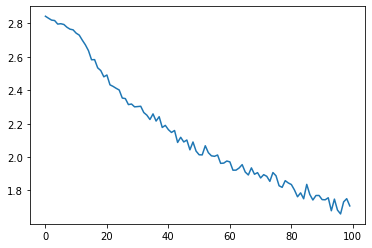

In [228]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\thoma\Documents\anaconda\envs\torchenv\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\thoma\Documents\anaconda\envs\torchenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


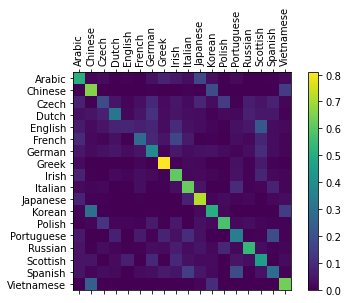

In [233]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [230]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.28) Polish
(-1.46) Russian
(-1.72) Czech

> Jackson
(-1.00) Scottish
(-1.54) Russian
(-2.01) English

> Satoshi
(-1.61) Italian
(-1.79) Polish
(-1.95) Japanese
